In [2]:
import importlib, os, gc, sys
import SXBQ as sx
import WMT_functions as wmt
import matplotlib.dates as mdates
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import fsolve, fmin
from scipy.signal import convolve as conv
import gsw
import cmocean.cm as cmo
from datetime import datetime as dt
import matplotlib.dates as mdates
import math
import matplotlib.colors as cl
from gsw import z_from_p, p_from_z, distance, SA_from_SP, CT_from_t, rho, distance, cp_t_exact
from scipy.signal import find_peaks
from scipy.stats import linregress
from matplotlib.gridspec import GridSpec
import glidertools as gt
import matplotlib.colors as colors
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
from matplotlib.gridspec import GridSpec
from scipy.interpolate import griddata

import seaborn as sns
sns.set(    rc={
         'axes.axisbelow': False,
         'axes.edgecolor': 'Black',
         'axes.facecolor': 'white',
         'axes.grid': False,
         'axes.labelcolor': 'k',
            
         'axes.spines.right': True,
         'axes.spines.top': True,
         'figure.facecolor': 'white',
         'lines.solid_capstyle': 'round',
         'patch.edgecolor': 'k',
         'patch.force_edgecolor': True,
         'text.color': 'k',
         'xtick.bottom': True,
         'xtick.color': 'k',
         'xtick.direction': 'out',
         'xtick.top': False,
         'ytick.color': 'k',
         'ytick.direction': 'out',
         'ytick.left': True,
         'ytick.right': False},
         font_scale=1.3)


import warnings
warnings.filterwarnings('ignore')

def interp(x,y,xi):
    _gg = np.isfinite(x+y)
    return interp1d(x[_gg], y[_gg], bounds_error=False, fill_value=np.NaN)(xi)

# import data

In [5]:
ds_79=xr.open_dataset('/home/jupyter-estelfont/datasets/glider_grid/sg79_gridded_pp_pressure.nc')
ds_79_DAC= xr.open_dataset('/home/jupyter-estelfont/common/fridge/2015_16_OMAN/SG579_timeseries.nc')
ds_79['DAC_u']=('profile_number', ds_79_DAC.DAC_u.rename({'dives':'dive_num'}).interp(dive_num=ds_79.dive_num.mean('pressure').round().values).values)
ds_79['DAC_v']=('profile_number', ds_79_DAC.DAC_v.rename({'dives':'dive_num'}).interp(dive_num=ds_79.dive_num.mean('pressure').round().values).values)

group_trans=ds_79.groupby_bins('transect_num', bins=np.arange(0,ds_79.transect_num.max(),1))
ds2_=xr.open_dataset('../../data/sea079_by_transect.nc')

In [7]:
def data_grid_roll(DS, climat_or_transect, month, var): # month, cons_temp, abs_salinity ,  potential_density , spice
    if climat_or_transect=='month':
        get_section1=DS.groupby('t.month')[month]
        def roll(ds):
            ds = pd.DataFrame(ds).interpolate(limit=5,axis=0).interpolate(limit=2,axis=1).rolling(5,axis=0, center=True).mean().rolling(10,axis=1, center=True).mean()
            return ds.to_numpy()
        dx, dy=1, 1
        xaxis=np.arange(0,80+dx,dx)
        yaxis=np.arange(0,500+dy,dy)

    elif climat_or_transect=='transect':
        get_section1=ds2_.sel(transect_number=month).where(ds2_.sel(transect_number=month).cons_temp.count('pressure')!=0, drop=True)
        def roll(ds):
            ds = pd.DataFrame(ds).interpolate(limit=2,axis=1).rolling(3,axis=1, center=True).mean()            
            return ds.to_numpy()
        dx, dy=2, 0.5
        xaxis=np.arange(0,80+dx,dx)
        yaxis=np.arange(0,500+dy,dy)


    if (var=='DAC_u'):
        XX1, YY1=np.meshgrid(get_section1.distance_bin_on_transect,  1)
        ct1, _ ,_=sx.grid2d(XX1.flatten(), YY1.flatten(), get_section1[var].values.flatten(), xi=xaxis, yi=[0,1], fn='mean')
        return_=roll(ct1)[0, int(10/dx):int(-7/dx)]
    elif (var=='DAC_v'):
        XX1, YY1=np.meshgrid(get_section1.distance_bin_on_transect,  1)
        ct1, _ ,_=sx.grid2d(XX1.flatten(), YY1.flatten(), get_section1[var].values.flatten(), xi=xaxis, yi=[0,1], fn='mean')
        return_=roll(ct1)[0, int(10/dx):int(-7/dx)] 
    else:
        XX1, YY1=np.meshgrid(get_section1.distance_bin_on_transect,  get_section1.pressure)
        ct1, _ ,_=sx.grid2d(XX1.flatten(), YY1.flatten(), get_section1[var].values.flatten(), xi=xaxis, yi=yaxis, fn='mean')
        return_=roll(ct1)[:, int(10/dx):int(-7/dx)]
    
    return return_


dx, dy=2, 0.5
xaxis=np.array(np.arange(0,80+dx,dx))[int(10/dx):int(-7/dx)]
yaxis=np.arange(0,500+dy,dy)

def regrided_in_XZ(xaxis, yaxis, S_var, T_var,  ts_trans,transectnu ):  #transectnu  5--> 23
    pressure = yaxis   # Pressure values
    distance = xaxis    # Distance values
    ## transect number start is 4 --> so if transectnu is 6; timestep is 6-4
    # transectnu=9
    timste=transectnu-5 
    salinity_noflat=data_grid_roll(ds2_, climat_or_transect, transectnu, S_var)
    temperature_noflat=data_grid_roll(ds2_,climat_or_transect, transectnu, T_var)
    salinity_noflat2=data_grid_roll(ds2_, climat_or_transect, transectnu+1, S_var)
    temperature_noflat2=data_grid_roll(ds2_,climat_or_transect, transectnu+1, T_var)

    remap_sal_mean=np.nanmean([salinity_noflat, salinity_noflat2], axis=0)
    remap_temp_mean=np.nanmean([temperature_noflat, temperature_noflat2], axis=0)
    
    # Create 2D grids for spice, density, pressure, and distance
    pressure_grid, distance_grid = np.meshgrid(pressure, distance)
    # Assume spice and density are gridded in pressure x distance space (e.g., obtained from data)
    # Here we're just creating a dummy example, in reality, you should use actual data
    spice_grid_pd = remap_sal_mean.T  # Example spice in pressure x distance grid
    density_grid_pd = remap_temp_mean.T  # Example density in pressure x distance grid
        # Here we're just creating a dummy example, in reality, you should use actual data
    # spice_grid_pd2 = salinity_noflat2.T  # Example spice in pressure x distance grid
    # density_grid_pd2 = temperature_noflat2.T  # Example density in pressure x distance grid
    # Now create your variable defined on the spice x density grid
    spice_values = ts_trans.S_bini.values
    density_values = ts_trans.T_bini.values
    dS=ts_trans.dS.item()
    dT=ts_trans.dT.item()
    dt=ts_trans.delta_time.isel(time_mid=timste).item()

    spice_grid_sd, density_grid_sd = np.meshgrid(spice_values, density_values)

    # Create a variable in spice x density grid (for example)
    Gs_spice_density = (ts_trans.G_si.isel(time_mid=timste).values/ts_trans.ts_vol.isel(time=(timste)*2).values)*dS*dt
    Gs_flux = (ts_trans.G_si.isel(time_mid=timste).values/ts_trans.ts_vol.isel(time=(timste)*2).values)*dx*1000*dy
    
    Gt_spice_density = (ts_trans.G_ti.isel(time_mid=timste).values/ts_trans.ts_vol.isel(time=(timste)*2).values)*dT*dt
    Gt_flux = (ts_trans.G_ti.isel(time_mid=timste).values/ts_trans.ts_vol.isel(time=(timste)*2).values)*dx*1000*dy
    
    # epsilon_spice_density = (ts_trans.epsilon.isel(time_mid=timste).values/ts_trans.ts_vol.isel(time=(timste)*2).values)
    # epsilon_spice_density= (np.abs(ts_trans_sigmaspice.isel(time_mid=timste).epsilon*100/(ts_trans_sigmaspice.isel(time=(timste)*2).ts_vol))<50).astype(float).values

    epsilon_spice_density=((np.abs(ts_trans.epsilon.isel(time_mid=timste))*100/(np.abs(ts_trans.dvol_G.isel(time_mid=timste))+np.abs(ts_trans.epsilon.isel(time_mid=timste))))>25).astype(float).values
    
    epsilon_spice_density[epsilon_spice_density==0]=np.nan
    
    if S_var=='abs_salinity':
        Gs_spice_density = (ts_trans.G_si.isel(time_mid=timste).values/ts_trans.ts_vol.isel(time=(timste)*2).values)*dS*dt
        Gs_flux = ((ts_trans.G_si.isel(time_mid=timste).values/ts_trans.ts_vol.isel(time=(timste)*2).values))*(dx*1000*dy)
        Gt_spice_density = (ts_trans.G_ti.isel(time_mid=timste).values/ts_trans.ts_vol.isel(time=(timste)*2).values)*dT*dt
        Gt_flux = ((ts_trans.G_ti.isel(time_mid=timste).values/ts_trans.ts_vol.isel(time=(timste)*2).values))*(dx*1000*dy)
        surfflux_spice_density = (ts_trans.dvol_E.isel(time_mid=timste).values)

    # ts_trans.G_s.isel(time_mid=0).values

    # Flatten the spice and density grids (from spice x density space)
    points = np.array([spice_grid_sd.flatten(), density_grid_sd.flatten()]).T
    valuesGS = Gs_spice_density.flatten()
    valuesGT = Gt_spice_density.flatten()
    valuesGSflux = Gs_flux.flatten()
    valuesGTflux = Gt_flux.flatten()
    
    valuesepsilon = epsilon_spice_density.flatten()

    if S_var=='abs_salinity':
        values_surflux=surfflux_spice_density.flatten()
    # Use the (spice, density) values from the (pressure, distance) grid for interpolation
    spice_density_points = np.array([spice_grid_pd.flatten(), density_grid_pd.flatten()]).T
    # spice_density_points2 = np.array([spice_grid_pd2.flatten(), density_grid_pd2.flatten()]).T

    # Perform interpolation from (spice, density) grid to the (pressure, distance) grid
    gs_pressure_distance = griddata(points, valuesGS, spice_density_points, method='linear')
    gt_pressure_distance = griddata(points, valuesGT, spice_density_points, method='linear')
    eps_pressure_distance = griddata(points, valuesepsilon, spice_density_points, method='linear')
    gs_pressure_distanceFLUX = griddata(points, valuesGSflux, spice_density_points, method='linear')
    gt_pressure_distanceFLUX = griddata(points, valuesGTflux, spice_density_points, method='linear')

    # gs_pressure_distance2 = griddata(points, valuesGS, spice_density_points2, method='linear')
    # gt_pressure_distance2 = griddata(points, valuesGT, spice_density_points2, method='linear')
    # eps_pressure_distance2 = griddata(points, valuesepsilon, spice_density_points2, method='linear')
    # gs_pressure_distanceFLUX2 = griddata(points, valuesGSflux, spice_density_points2, method='linear')
    # gt_pressure_distanceFLUX2 = griddata(points, valuesGTflux, spice_density_points2, method='linear')

    if S_var=='abs_salinity':
        surfflux_pressure_distance = griddata(points, values_surflux, spice_density_points, method='linear')
        # surfflux_pressure_distance2 = griddata(points, values_surflux, spice_density_points2, method='linear')

    # Reshape the result to the shape of the (pressure, distance) grid
    gs_pressure_distance = gs_pressure_distance.reshape(pressure_grid.shape)
    gt_pressure_distance = gt_pressure_distance.reshape(pressure_grid.shape)
    eps_pressure_distance = eps_pressure_distance.reshape(pressure_grid.shape)
    gs_pressure_distanceFLUX = gs_pressure_distanceFLUX.reshape(pressure_grid.shape)
    gt_pressure_distanceFLUX = gt_pressure_distanceFLUX.reshape(pressure_grid.shape)
    
    # gs_pressure_distance2 = gs_pressure_distance2.reshape(pressure_grid.shape)
    # gt_pressure_distance2 = gt_pressure_distance2.reshape(pressure_grid.shape)
    # eps_pressure_distance2 = eps_pressure_distance2.reshape(pressure_grid.shape)
    # gs_pressure_distanceFLUX2 = gs_pressure_distanceFLUX2.reshape(pressure_grid.shape)
    # gt_pressure_distanceFLUX2 = gt_pressure_distanceFLUX2.reshape(pressure_grid.shape)
    
    if S_var=='abs_salinity':
        surfflux_pressure_distance = surfflux_pressure_distance.reshape(pressure_grid.shape)
        # surfflux_pressure_distance2 = surfflux_pressure_distance2.reshape(pressure_grid.shape)
    
    data = {
        "temperature1": temperature_noflat,
        "salinity1": salinity_noflat,
        "temperature2": temperature_noflat2,
        "salinity2": salinity_noflat2,
        "gs_distance": gs_pressure_distance,
        "gt_distance": gt_pressure_distance,
        "gs_flux_distance": gs_pressure_distanceFLUX,
        "gt_flux_distance":gt_pressure_distanceFLUX,
        
        "eps_distance": eps_pressure_distance,
        "temp_mean": remap_temp_mean, 
        
        
    }

    if S_var == 'abs_salinity' and surfflux_pressure_distance is not None:
        data["surfflux_distance"] = surfflux_pressure_distance
        
    return data
        
        
climat_or_transect='transect'

ts_trans_sigmaspice=xr.open_dataset('../../data/WMT_sg079_2dt_0.1_0.05.nc')
# ts_trans_ts=xr.open_dataset('../data/WMT_sg079_step_1transect_TS.nc')

max_dpth=200


ts_trans_sigmaspice['G_si']=ts_trans_sigmaspice.G_si.where(ts_trans_sigmaspice.G_si!=0, np.nan)
ts_trans_sigmaspice['G_ti']=ts_trans_sigmaspice.G_ti.where(ts_trans_sigmaspice.G_ti!=0, np.nan)
# ts_trans_ts['G_si']=ts_trans_ts.G_si.where(ts_trans_ts.G_si!=0, np.nan)
# ts_trans_ts['G_ti']=ts_trans_ts.G_ti.where(ts_trans_ts.G_ti!=0, np.nan)
   

### Plotting functions

In [8]:
from matplotlib.colors import LinearSegmentedColormap
def get_cmap():
    """
    Create and return a custom colormap for visualizations.

    This function generates a linear segmented colormap that transitions through a specified 
    set of colors, ordered from dark red to dark blue. The colormap is defined using 
    hexadecimal color codes and is intended for use in visualizations where a smooth 
    transition between these colors is desired.

    Returns
    -------
    cmap : matplotlib.colors.LinearSegmentedColormap
        A custom colormap object that can be used in plotting functions to map data values 
        to colors.

    Notes
    -----
    - The colormap transitions through the following colors (in reverse order for the final colormap):
      '#053061', '#2166ac', '#4393c3', '#92c5de', '#d1e5f0', '#f7f7f7', 
      '#fddbc7', '#f4a582', '#d6604d', '#b2182b', '#67001f'.
    - The resulting colormap can be applied to any data visualization that supports colormaps, 
      such as those created with matplotlib.
    
    Example
    -------
    >>> cmap = get_cmap()
    >>> plt.imshow(data, cmap=cmap)
    >>> plt.colorbar()
    """
    
    # Define the colors in the order you've specified
    colors = ['#67001f', '#b2182b', '#d6604d', '#f4a582', '#fddbc7', '#f7f7f7', '#d1e5f0', '#92c5de', '#4393c3', '#2166ac', '#053061']
    # Create a colormap that transitions from the first color to the last
    cmap_name = 'custom_cmap'
    cmap = LinearSegmentedColormap.from_list('custom_cmap', colors[::-1])
    return cmap

br=get_cmap()


def ts_ax(ax, tmin, tmax, smin, smax):
    # limto=4
    fns=10
    mins,maxs= smin, smax
    mint,maxt=tmin, tmax
    tempL,salL=np.linspace(mint,maxt,1000), np.linspace(mins,maxs,1000)
    Wg, Qg = np.meshgrid(tempL,salL)
    
    sig = gsw.sigma0(Qg, Wg)
    spc = gsw.spiciness0(Qg, Wg)
    
    
    CS=ax.contour(Qg, Wg, sig, colors='silver', linestyles='dashed', linewidths=1, levels=np.arange(18,37,0.25))
    ax.clabel(CS, fontsize=fns-1, inline=1, fmt='%0.2f')
    CS=ax.contour(Qg, Wg, sig, colors='k', linestyles='dashed', linewidths=1, levels=[25, 25.25])
    ax.clabel(CS, fontsize=fns-1, inline=1, fmt='%0.2f')
    CS=ax.contour(Qg, Wg, sig, colors='red', linestyles='dashed', linewidths=1, levels=[24.75, 25.5])
    ax.clabel(CS, fontsize=fns-1, inline=1, fmt='%0.2f')
    
    
    CS=ax.contour(Qg, Wg, spc, colors='green', linestyles='dashed', linewidths=1, levels=np.arange(2,10,0.5))
    ax.clabel(CS, fontsize=fns-1, inline=1, fmt='%0.1f')
    
    return

In [9]:
def plot_section_and_transformation(trans_number_):
    time_stamp=pd.to_datetime(ts_trans_sigmaspice.isel(time_mid=(trans_number_-5)).time_mid.values).strftime('%d %b')
    time_stamp_pls1=pd.to_datetime(ts_trans_sigmaspice.isel(time_mid=(trans_number_-5)+1).time_mid.values).strftime('%d %b')

    data_sigsp=regrided_in_XZ(xaxis, yaxis,'spice', 'potential_density', ts_trans_sigmaspice, trans_number_)
    density_grid, spice_grid, gspice_xz, gsigma_xz, eps_sigspc_xz=data_sigsp['temperature1'], data_sigsp['salinity1'],data_sigsp['gs_distance'],data_sigsp['gt_distance'],data_sigsp['eps_distance']
    gsflux_sigma, gtflux_sigma=data_sigsp['gs_flux_distance'],data_sigsp['gt_flux_distance']

    dens_mean=data_sigsp['temp_mean']
    density_grid2=data_grid_roll(ds2_, climat_or_transect, trans_number_+1, 'potential_density')
    spice_grid2=data_grid_roll(ds2_,climat_or_transect, trans_number_+1, 'spice')
    salinity_grid2=data_grid_roll(ds2_, climat_or_transect, trans_number_+1, 'abs_salinity')
    temperature_grid2=data_grid_roll(ds2_,climat_or_transect, trans_number_+1, 'cons_temp')

    def set_colorbar(cb, vmin, vmax):
        cb.set_ticks(np.linspace(vmin, vmax, 5)) 

    fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(8, 17), constrained_layout=True)

    # First Row - First Timestamp
    axes[0, 0].set_title("Density")
    cb1 = axes[0, 0].contourf(xaxis, yaxis, density_grid, np.arange(23, 26.5+0.25, 0.25), cmap=cmo.dense)
    axes[0, 0].contour(xaxis, yaxis, density_grid, levels=np.arange(23, 26.5+0.25, 0.25), colors='silver')
    axes[0, 0].contour(xaxis, yaxis, density_grid, levels=[24.75, 25.5], colors='red')
    axes[0, 0].contour(xaxis, yaxis, density_grid, levels=[25, 25.25], colors='k')
    axes[0, 0].text(15, 20, s=time_stamp, c='k')

    axes[0, 1].set_title("Spice")
    cb2 = axes[0, 1].contourf(xaxis, yaxis, spice_grid, np.arange(4, 7.5+0.1,  0.1), cmap=cmo.deep_r)
    axes[0, 1].contour(xaxis, yaxis, density_grid, levels=np.arange(23, 26.5+0.25, 0.25), colors='silver')
    axes[0, 1].contour(xaxis, yaxis, density_grid, levels=[24.75, 25.5], colors='red')
    axes[0, 1].contour(xaxis, yaxis, density_grid, levels=[25, 25.25], colors='k')


    cb5 = axes[1, 0].contourf(xaxis, yaxis, density_grid2, np.arange(23, 26.5+0.25, 0.25), cmap=cmo.dense)
    cbar5 =fig.colorbar(cb5, ax=axes[1, 0], orientation='horizontal', extend='both')
    axes[1, 0].contour(xaxis, yaxis, density_grid2, levels=np.arange(23, 26.5+0.25, 0.25), colors='silver')
    axes[1, 0].contour(xaxis, yaxis, density_grid2, levels=[24.75, 25.5], colors='red')
    axes[1, 0].contour(xaxis, yaxis, density_grid2, levels=[25, 25.25], colors='k')
    axes[1, 0].text(15, 20, s=time_stamp_pls1, c='k')
    set_colorbar(cbar5, 23, 26.5)
    norm_25 = cbar5.norm(24.75) 
    cbar5.ax.plot([norm_25, norm_25], [0, 1], color='red',  linewidth=1.5, transform=cbar5.ax.transAxes)
    norm_25 = cbar5.norm(25.5) 
    cbar5.ax.plot([norm_25, norm_25], [0, 1], color='red',  linewidth=1.5, transform=cbar5.ax.transAxes)
    norm_25 = cbar5.norm(25) 
    cbar5.ax.plot([norm_25, norm_25], [0, 1], color='k',  linewidth=1.5, transform=cbar5.ax.transAxes)
    norm_25 = cbar5.norm(25.25) 
    cbar5.ax.plot([norm_25, norm_25], [0, 1], color='k',  linewidth=1.5, transform=cbar5.ax.transAxes)

    # axes[1, 1].set_title("Spice (Second Time)")
    cb6 = axes[1, 1].contourf(xaxis, yaxis, spice_grid2, np.arange(4, 7.5+0.1,  0.1), cmap=cmo.deep_r)
    cbar6 = fig.colorbar(cb6, ax=axes[1, 1], orientation='horizontal', extend='both')
    axes[1, 1].contour(xaxis, yaxis, density_grid2, levels=np.arange(23, 26.5+0.25, 0.25), colors='silver')
    axes[1, 1].contour(xaxis, yaxis, density_grid2, levels=[24.75, 25.5], colors='red')
    axes[1, 1].contour(xaxis, yaxis, density_grid2, levels=[25, 25.25], colors='k')
    set_colorbar(cbar6, 4, 7.5)


    axes[2, 0].set_title("diapycnal flux")
    
    cb9 = axes[2, 0].pcolormesh(xaxis, yaxis, gtflux_sigma.T, vmin=-0.005,  vmax=0.005, cmap=br)
    cbar09=fig.colorbar(cb9, ax=axes[2, 0], orientation='horizontal', extend='both')
    xx, yy=np.meshgrid(xaxis, yaxis)
    valid_mask = ~np.isnan(eps_sigspc_xz.T)
    x_valid = xx[valid_mask]
    z_valid = yy[valid_mask]
    
    axes[2, 0].scatter(x_valid, z_valid, s=1, c='silver', marker='x')
    axes[2, 1].set_title("isopycnal flux")
    cb10 = axes[2, 1].pcolormesh(xaxis, yaxis, gsflux_sigma.T,  vmin=-0.005,  vmax=0.005, cmap=br)
    axes[2, 1].scatter(x_valid, z_valid, s=1, c='silver', marker='x')
    
    for ind, cbbs in enumerate([cbar09]):
        cbbs.set_label('m2 s', fontsize=13)


    # Adjust y-axis limits
    for ax in axes.flatten():
        ax.set_ylim(max_dpth, 0)
    for ax in axes.flatten()[:8+4]:
        ax.set_xticks([])
    for ax in axes.flatten()[1:4]:
        ax.set_yticks([])
    for ax in axes.flatten()[5:8]:
        ax.set_yticks([])
    for ax in axes.flatten()[9:12]:
        ax.set_yticks([])
    for ax in axes.flatten()[13:16]:
        ax.set_yticks([])
    for ax in axes.flatten()[8:12+4]: 
        ax.contour(xaxis, yaxis, dens_mean, levels=np.arange(23, 26.5+0.25, 0.25), colors='silver')
        ax.contour(xaxis, yaxis, dens_mean, levels=[24.75, 25.5], colors='red')
        ax.contour(xaxis, yaxis, dens_mean, levels=[25, 25.25], colors='k')
    
    ## TRANSF IN SIG SPICE
    
    rownum_=4
    
    ts_trans_sigmaspice['G_si']=ts_trans_sigmaspice.G_si.where(ts_trans_sigmaspice.G_si!=0, np.nan)
    ts_trans_sigmaspice['G_ti']=ts_trans_sigmaspice.G_ti.where(ts_trans_sigmaspice.G_ti!=0, np.nan)
    
    axes[rownum_, 0].set_title("Water mass Area Change")
    cb13 = axes[rownum_, 0].pcolormesh(ts_trans_sigmaspice.S_bini, ts_trans_sigmaspice.T_bini, ts_trans_sigmaspice.dvol_G.isel(time_mid=(trans_number_-5))/100000, cmap=br, vmin=-2 ,vmax=2)
    cbar13 = fig.colorbar(cb13, ax=axes[rownum_, 0], orientation='horizontal', extend='both')
    set_colorbar(cbar13, -2, 2)
    cbar13.set_label('($x10^5$ $m^2$)', fontsize=13)
    
    axes[rownum_, 0].contour(xaxis, yaxis, density_grid, levels=np.arange(22, 26.5+0.25, 0.25), colors='silver')
    axes[rownum_, 0].contour(xaxis, yaxis, density_grid, levels=[24.75, 25.5], colors='red')
    axes[rownum_, 0].contour(xaxis, yaxis, density_grid, levels=[25, 25.25], colors='k')
    axes[rownum_, 0].quiver(ts_trans_sigmaspice.S_bini,  ts_trans_sigmaspice.T_bini, ts_trans_sigmaspice.G_si.isel(time_mid=(trans_number_-5)), -ts_trans_sigmaspice.G_ti.isel(time_mid=(trans_number_-5)), 
             angles='uv', color='k', scale=5)
    axes[rownum_,0].set_ylim(25.55, 24.7)
    axes[rownum_,0].set_xlim(4.3,6.3)
    axes[rownum_,0].axhline(24.75, color='red')
    axes[rownum_,0].axhline(25.5, color='red')
    axes[rownum_,0].axhline(25.25, color='k')
    axes[rownum_,0].axhline(25, color='k')
    
    axes[rownum_, 1].set_title("Epsilon Area Change")
    cb13 = axes[rownum_, 1].pcolormesh(ts_trans_sigmaspice.S_bini, ts_trans_sigmaspice.T_bini, ts_trans_sigmaspice.epsilon.isel(time_mid=(trans_number_-5))/100000, cmap=br, vmin=-2 ,vmax=2)
    axes[rownum_, 1].contour(xaxis, yaxis, density_grid, levels=np.arange(22, 26.5+0.25, 0.25), colors='silver')
    axes[rownum_, 1].contour(xaxis, yaxis, density_grid, levels=[24.75, 25.5], colors='red')
    axes[rownum_, 1].contour(xaxis, yaxis, density_grid, levels=[25, 25.25], colors='k')
    axes[rownum_,1].set_ylim(25.55, 24.7)
    axes[rownum_,1].set_xlim(4.3,6.3)
    axes[rownum_,1].axhline(24.75, color='red')
    axes[rownum_,1].axhline(25.5, color='red')
    axes[rownum_,1].axhline(25.25, color='k')
    axes[rownum_,1].axhline(25, color='k')
    axes[rownum_,1].set_yticks([])
    

In [12]:
def get_section_and_transformation(trans_number_):
    # trans_number_=13
    time_stamp=pd.to_datetime(ts_trans_sigmaspice.isel(time_mid=(trans_number_-5)).time_mid.values).strftime('%d %b')
    # time_stamp_pls1=pd.to_datetime(ts_trans_ts.isel(time_mid=trans_number_+1).time_mid.values).strftime('%d %b')

    # data_ts=regrided_in_XZ(xaxis, yaxis,'abs_salinity', 'cons_temp', ts_trans_ts, trans_number_)
    # temperature_grid, salinity_grid, gs_xz, gt_xz, eps_ts_xz, surf_ts_xz=data_ts['temperature1'], data_ts['salinity1'],data_ts['gs_distance'],data_ts['gt_distance'],data_ts['eps_distance'],data_ts['surfflux_distance']
    # gsflux_ts, gtflux_ts=data_ts['gs_flux_distance'],data_ts['gt_flux_distance']

    data_sigsp=regrided_in_XZ(xaxis, yaxis,'spice', 'potential_density', ts_trans_sigmaspice, trans_number_)
    density_grid, spice_grid, gspice_xz, gsigma_xz,eps_sigspc_xz=data_sigsp['temperature1'],data_sigsp['salinity1'],data_sigsp['gs_distance'],data_sigsp['gt_distance'],data_sigsp['eps_distance']
    gsflux_sigma, gtflux_sigma=data_sigsp['gs_flux_distance'],data_sigsp['gt_flux_distance']
    
    dens_mean=data_sigsp['temp_mean']
    
    # ts_trans_sigmaspice.dT.item(), ts_trans_sigmaspice.dS.item()
    time_grid=data_grid_roll(ds2_, climat_or_transect, trans_number_, 'time')
    
    # return gs_xz, gt_xz, eps_ts_xz, time_grid, gspice_xz, gsigma_xz, eps_sigspc_xz, temperature_grid, salinity_grid, density_grid, spice_grid, dens_mean
    # return gsflux_ts, gtflux_ts, eps_ts_xz, time_grid, gsflux_sigma, gtflux_sigma, eps_sigspc_xz, temperature_grid, salinity_grid, density_grid, spice_grid, dens_mean
    return time_grid, gsflux_sigma, gtflux_sigma, eps_sigspc_xz, density_grid, spice_grid, dens_mean
    

In [13]:
arr_of_prof=[]
for i in tqdm(range(5,23)):
    time_grid_i, gspice_xz_i, gsigma_xz_i, eps_sigspc_xz_i,  density_grid_i, spice_grid_i, mean_density_i= get_section_and_transformation(i)

    ds_i = xr.Dataset(
        {   
            # "G_s": (["time", "depth"], gs_xz_i),
            # "G_t": (["time", "depth"], gt_xz_i),
            "G_spice": (["time", "depth"], gspice_xz_i),
            "G_sigma": (["time", "depth"], gsigma_xz_i),
            # "epsilon_ts": (["time", "depth"], eps_ts_xz_i),
            "epsilon_sigmaspice": (["time", "depth"], eps_sigspc_xz_i),
            # "temp": (["time", "depth"], temperature_grid_i.T),
            # "sal": (["time", "depth"], salinity_grid_i.T),
            "spice": (["time", "depth"], spice_grid_i.T),
            "sigma": (["time", "depth"], density_grid_i.T),
            "mean_density": (["time", "depth"], mean_density_i.T),
             "distance": ('time', xaxis),
            "transect_number" : ('time', xaxis*0+i)
         
        },
        coords={"time": pd.to_datetime(np.nanmean(time_grid_i, axis=0)),"depth": yaxis,},attrs={},)
    arr_of_prof.append(ds_i)
    if i ==5:
        ds_conc=ds_i.copy()
    else:
        ds_conc=xr.concat([ds_conc, ds_i], 'time').sortby('time')

  0%|          | 0/18 [00:00<?, ?it/s]

In [14]:
ds_79_t=xr.open_dataset('/home/jupyter-estelfont/datasets/glider_grid/sg79_gridded_time_pressure.nc')

ds_conc['mask_epsilon']=ds_conc.epsilon_sigmaspice.where(np.isnan(ds_conc.epsilon_sigmaspice), 0)

c_isopyc='#558C8C'
c_diapy='#963D5A'

In [18]:
# plt.text(ts_trans_sigmaspice.time_mid.values[0], 1, s='1')


In [15]:
import matplotlib.gridspec as gridspec

# --- Helper functions ---
def plot_g(ax, data, cmap, title):
    to_grid = data.where(ds_conc.mask_epsilon != 0)
    pcol = ax.pcolormesh(np.unique(ds_conc.distance), ds_conc.depth,
                         to_grid.where(np.isfinite(to_grid)).groupby(ds_conc.distance).median().T,
                         vmin=-0.002, vmax=0.002, cmap=plt.get_cmap('cmo.balance', 16))
    ax.set_ylim(200, 0)
    ax.set_title(title, color='k')
    return pcol

def plot_contours(ax):
    sigma_median = ds_conc['sigma'].where(np.isfinite(ds_conc['sigma'])).groupby(ds_conc.distance).median().T
    spice_median = ds_conc['spice'].where(np.isfinite(ds_conc['spice'])).groupby(ds_conc.distance).median().T

    nan_col_start = xr.full_like(sigma_median.isel(distance=0), np.nan).expand_dims(distance=[8]).T
    nan_col_end = xr.full_like(sigma_median.isel(distance=0), np.nan).expand_dims(distance=[76]).T
    sigma_median = xr.concat([nan_col_start, sigma_median, nan_col_end], dim='distance').bfill('distance').ffill('distance')

    nan_col_start = xr.full_like(spice_median.isel(distance=0), np.nan).expand_dims(distance=[8]).T
    nan_col_end = xr.full_like(spice_median.isel(distance=0), np.nan).expand_dims(distance=[76]).T
    spice_median = xr.concat([nan_col_start, spice_median, nan_col_end], dim='distance').bfill('distance').ffill('distance')

    ax.contour(np.unique(spice_median.distance), ds_conc.depth, sigma_median,
               levels=np.arange(22, 28, 0.25), colors='k', alpha=0.5, linewidths=2)
    ax.contour(np.unique(spice_median.distance), ds_conc.depth, sigma_median,
               levels=[25, 25.25], colors='red', linestyles='-', linewidths=2)
    ax.contour(np.unique(spice_median.distance), ds_conc.depth, spice_median,
               levels=np.arange(1, 9, 0.5), linestyles=':', colors='k', alpha=0.5, linewidths=2)
    # ax.contourf(np.unique(spice_median.distance), ds_conc.depth, sigma_median,
    #            levels=[20,24.5], colors='w')
    cf = ax.contourf(np.unique(spice_median.distance), ds_conc.depth, sigma_median, levels=[20, 24.5], colors='white', hatches=['//'], zorder=100)

    # Ensure hatching appears in black
    # for cl in cf.collections:
    #     cl.set_edgecolor('black')
    #     cl.set_linewidth(0.5)  # Optional: control thickness

def plot_bar(ax, timestep_data, di=0.25, colors=[c_diapy, c_isopyc, 'gray']):
    # labels__ = []
    for i in np.arange(24.5, 25.75, di):
        sig_ = slice(i, i + di)
        b = timestep_data.G_ti.sel(S_bini=slice(4.3, 6.3), T_bini=sig_).sum('T_bini').mean('time_mid')
        c = timestep_data.G_si.sel(S_bini=slice(4.3, 6.3), T_bini=sig_).sum('T_bini').mean('time_mid')
        d = (timestep_data.epsilon / timestep_data.delta_time).sel(S_bini=slice(4.3, 6.3), T_bini=sig_).sum('T_bini').mean('time_mid')
        ax.barh([i + di/4, i + 2*di/4, i + 3*di/4],
                [b.sum('S_bini'), c.sum('S_bini'), d.sum('S_bini')],
                xerr=[b.std('S_bini'), c.std('S_bini'), d.std('S_bini')],
                height=di/4, color=colors, alpha=0.8,
                label=['Diapycnal', 'Isopycnal', 'Exchange'] if i == 24.5 else None)
        # labels__.append(f'{i:.2f}-{i+di:.2f}')
    ax.set_yticks(np.arange(24.5, 25.75+di, di))
    # ax.set_yticklabels(labels__)
    ax.set_ylim(25.75, 24.5)
    ax.axhline(25.25, c='red')
    ax.axhline(25, c='red')
    ax.axhline(24.75, c='gray')
    ax.axhline(25.5, c='gray')
    return ax


def plot_bar_timestep(ax, timestep_data, di=0.25, colors=[c_diapy, c_isopyc, 'gray']):
    labels__ = []
    for i in np.arange(24.5, 25.75, di):
        sig_ = slice(i, i + di)
        b = timestep_data.G_ti.sel(S_bini=slice(4.3, 6.3), T_bini=sig_).sum('T_bini')#.mean('time_mid')
        c = timestep_data.G_si.sel(S_bini=slice(4.3, 6.3), T_bini=sig_).sum('T_bini')#.mean('time_mid')
        d = (timestep_data.epsilon / timestep_data.delta_time).sel(S_bini=slice(4.3, 6.3), T_bini=sig_).sum('T_bini')#.mean('time_mid')
        ax.barh([i + di/4, i + 2*di/4, i + 3*di/4],
                [b.sum('S_bini'), c.sum('S_bini'), d.sum('S_bini')],
                xerr=[b.std('S_bini'), c.std('S_bini'), d.std('S_bini')],
                height=di/4, color=colors, alpha=0.8,
                label=['Diapycnal', 'Isopycnal', 'Exchange'] if i == 24.5 else None)
        # labels__.append({i:.2f}-{i+di:.2f}')
    # ax.set_yticks(np.arange(24.5 + di/2, 25.75, di))
    ax.set_yticks(np.arange(24.5, 25.75+di, di))
    # ax.set_yticklabels(labels__)
    ax.set_ylim(25.75, 24.5)
    ax.axhline(25.25, c='red')
    ax.axhline(25, c='red')
    ax.axhline(24.75, c='gray')
    ax.axhline(25.5, c='gray')
    return ax

def plot_single_profile(ax, prof, field, xaxis, yaxis, cmap):
    ax.pcolormesh(xaxis, yaxis, getattr(prof, field).T, vmin=-0.002, vmax=0.002, cmap=plt.get_cmap('cmo.balance', 16))
    xx, yy = np.meshgrid(xaxis, yaxis)
    valid_mask = ~np.isnan(prof.epsilon_sigmaspice.T)
    ax.scatter(xx[valid_mask], yy[valid_mask], s=1, c='k', alpha=0.7, marker='x')
    ax.set_ylim(200, 0)

def plot_sigma_contours(ax, prof1, prof2, xaxis, yaxis):
    prof1=prof1.swap_dims({'time':'distance'})
    prof2=prof2.swap_dims({'time':'distance'})

    nan_col_start = xr.full_like(prof1.isel(distance=0), np.nan).expand_dims(distance=[8])
    nan_col_end = xr.full_like(prof1.isel(distance=0), np.nan).expand_dims(distance=[76])
    prof1 = xr.concat([nan_col_start, prof1, nan_col_end], dim='distance').bfill('distance').ffill('distance')
    nan_col_start = xr.full_like(prof2.isel(distance=0), np.nan).expand_dims(distance=[8])
    nan_col_end = xr.full_like(prof2.isel(distance=0), np.nan).expand_dims(distance=[76])
    prof2 = xr.concat([nan_col_start, prof2, nan_col_end], dim='distance').bfill('distance').ffill('distance')

    
    for prof, ls in zip([prof1, prof2], [':', '-']):
        ax.contour(prof1.distance, prof1.depth, prof.sigma.T, levels=[24.75, 25, 25.25, 25.5],
                   colors=['gray', 'red', 'red', 'gray'], linestyles=ls, linewidths=2)
        ax.contourf(prof1.distance, prof1.depth, prof.sigma.T,
               levels=[20,24.5], colors='white', hatches=['//'], zorder=100)           # sets hatch color (works in recent matplotlib)


In [16]:
argo_trans=xr.open_dataset('/home/jupyter-estelfont/3_MW_budget/data/Argo_bymonth_WMT_01_0.05.nc')
argo_transMEAN=xr.open_dataset('/home/jupyter-estelfont/3_MW_budget/data/ArgoAPRILJULY_WMT_01_0.05.nc').isel(time_mid=0)
dsargo=xr.open_dataset('/home/jupyter-estelfont/datasets/argo/ModeWater_SoO/gridded_along_across_SoO_per_month.nc')


mid_period = np.concatenate([np.arange(0, 6), np.arange(9, 15), np.arange(16, 17)]) #
early_late = np.concatenate([np.arange(6, 9), np.arange(15, 16)]) #4


sigma_prof_noed=[]
for i in early_late:
    sigma_prof_noed.append(arr_of_prof[i].sigma.mean('time'))

sigma_prof_ed=[]
for i in mid_period:
    sigma_prof_ed.append(arr_of_prof[i].sigma.mean('time'))



spic_prof_noed=[]
for i in early_late:
    spic_prof_noed.append(arr_of_prof[i].spice.mean('time'))

spic_prof_ed=[]
for i in mid_period:
    spic_prof_ed.append(arr_of_prof[i].spice.mean('time'))

## PLOT FIGURE 5

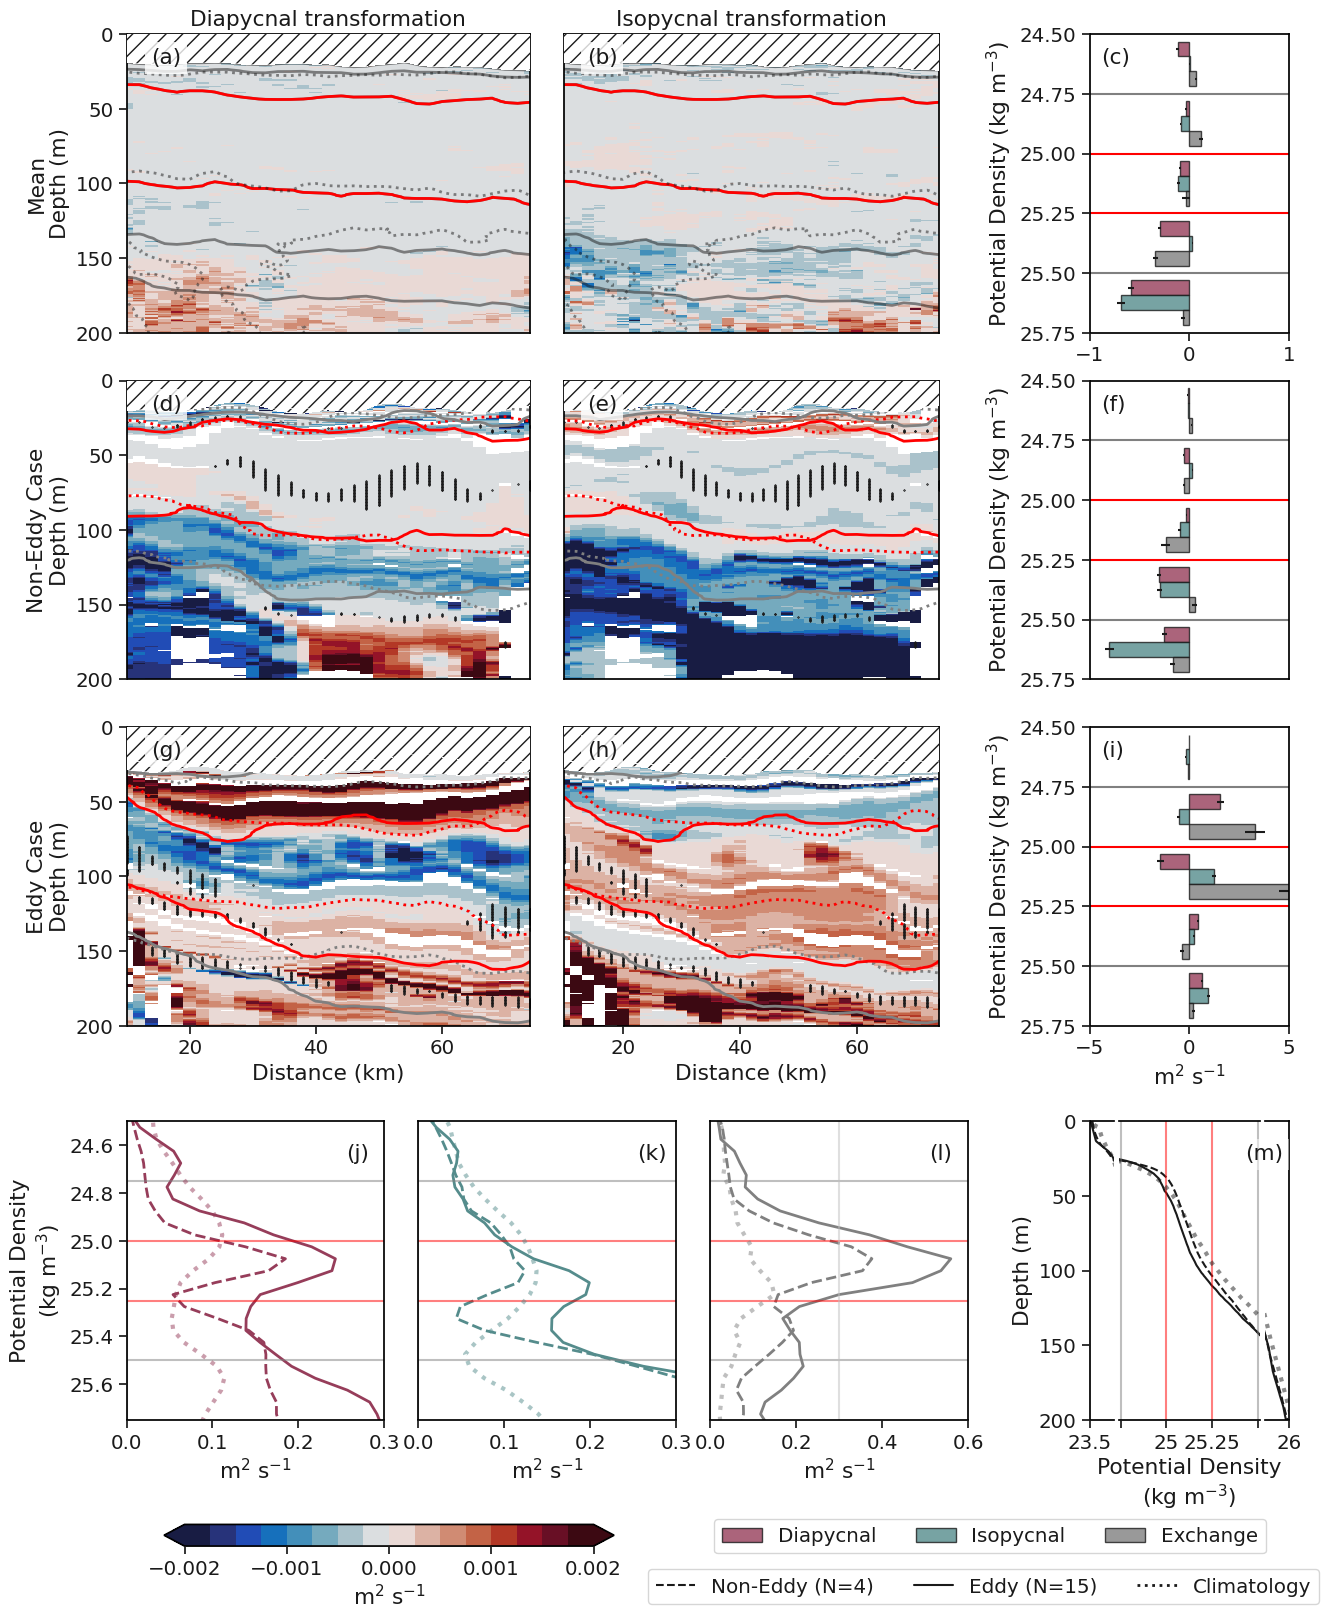

In [64]:
# --- Create figure and gridspec layout ---
# fig = plt.figure(figsize=(14, 18))
# gs = gridspec.GridSpec(nrows=5, ncols=4, width_ratios=[1, 1, 0.15, 0.75], height_ratios=[1, 1, 1, 0, 1])
# axes = [fig.add_subplot(gs[i, j]) for i in range(5) for j in range(4)]

# --- Create figure and gridspec layout ---
# 
# --- Create figure and gridspec layout ---
fig = plt.figure(figsize=(15, 18))
gs = gridspec.GridSpec(nrows=5, ncols=40, height_ratios=[1, 1, 1, 0, 1])
axes=[]
for j in range(3):
    axes.append(fig.add_subplot(gs[j, 0:14]))
    axes.append(fig.add_subplot(gs[j, 15:28]))
    axes.append(fig.add_subplot(gs[j, 29:32]))
    axes.append(fig.add_subplot(gs[j, 33:40]))
# ax_=fig.add_subplot(gs[0:3, j])


# ax4.set_ylabel('lol', loc='right')
# plt.savefig('Fig5.png', dpi=600)

# ax4.set_ylabel('lol', loc='right')
# plt.savefig('Fig5.png', dpi=600)

# --- Layout tweaks: remove ticks for cleaner subplots ---
for i in range(5):
    for j in range(4):
        ax = axes[i  + j]
        if i < 3:
            ax.set_xticks([])
        # if  :



# --- Top row: median sections ---
pcol=plot_g(axes[1], ds_conc.G_spice, cmap=cmo.balance, title='Isopycnal transformation')

plot_contours(axes[1])
axes[1].set_yticks([])
axes[1].set_xlim(10,74)


plot_g(axes[0], ds_conc.G_sigma, cmap=cmo.balance, title='Diapycnal transformation')
plot_contours(axes[0])
axes[0].set_xlim(10,74)

plot_bar(axes[3], ts_trans_sigmaspice)
axes[3].set_xlim(-1, 1)
axes[3].set_xticks([-1,0,1])

# --- Middle and bottom row: time steps ---
timesteps = [4, 10]
for idx, t in enumerate(timesteps):
    offset = 4 + idx * 4
    plot_single_profile(axes[offset+1], arr_of_prof[t], 'G_spice', xaxis, yaxis, br)
    plot_sigma_contours(axes[offset+1], arr_of_prof[t], arr_of_prof[t+1], xaxis, yaxis)
    axes[offset + 1].set_yticks([])
    axes[offset + 1].set_xlim(10,74)
    plot_single_profile(axes[offset], arr_of_prof[t], 'G_sigma', xaxis, yaxis, br)
    plot_sigma_contours(axes[offset], arr_of_prof[t], arr_of_prof[t+1], xaxis, yaxis)
    axes[offset].set_xlim(10,74)

    plot_bar_timestep(axes[offset + 3], ts_trans_sigmaspice.isel(time_mid=t))
    axes[offset + 3].set_xlim(-5, 5)
    if idx == 1:
        axes[offset + 3].set_xlabel('m$^{2}$ s$^{-1}$' )
    else:
        axes[offset + 3].set_xticks([])

# --- Label axes ---
# for i in [0, 4, 8]:
#     axes[i].set_ylabel('Depth (m)')

# for i in [0, 3, 6]:
axes[0].set_ylabel('Mean\nDepth (m)')
axes[4].set_ylabel('Non-Eddy Case\nDepth (m)')
axes[8].set_ylabel('Eddy Case\nDepth (m)')

for i in [3, 7, 11]:
    axes[i].set_ylabel('Potential Density (kg m$^{-3})$')
for i in [9, 8]:
    axes[i].set_xlabel('Distance (km)')


for i in [2,6,10]:
    axes[i].set_visible(False)
# for i in [12,13,14, 15]:
#     axes[i].set_visible(False)
# --- Legend ---
axes[11].legend(loc='lower center', ncol=3, bbox_to_anchor=(-0.5, -1.8))

# plt.tight_layout()


cbar_ax = fig.add_axes([0.15, 0.04, 0.3,  0.012])  # [left, bottom, width, height] in figure coordinates

# Add colorbar to that axis
cbar = fig.colorbar(pcol, orientation='horizontal', extend='both',  label='m$^{2}$ s$^{-1}$', cax=cbar_ax)

letterss=['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)', '(i)', '(j)', '(k)', '(l)']
for i, m in enumerate([0,1,3,4,5,7,8,9,11]):
    # print(i)
    axes[m].text(0.06, 0.9, letterss[i], transform=axes[m].transAxes,  bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'), zorder=100)





def plot_transformation(ax, data, T_bini, label_color, full_time, early_late, mid_period, S_slice):
    ax.axvline(0, c='silver')

    def plot_mean(selector, color, lss):
        val = np.abs(data.isel(time_mid=selector).sel(S_bini=S_slice).sum('S_bini')).mean('time_mid').rolling(T_bini=3, center=True).mean()
        ax.plot(val, T_bini, c=color, ls=lss, lw=2)

    # Full period
    # plot_mean(full_time, label_color, '-')
    # Mid period
    plot_mean(mid_period, label_color, '-')
    # Early + late
    plot_mean(early_late, label_color, '--')

    # Axis styling
    ax.set_ylim(25.75, 24.5)
    ax.set_xlim(0, 0.3)
    # ax.set_xlabel('abs(Transformation)')

    # Reference density lines
    for y in [25.25, 25.0]:
        ax.axhline(y, c='red', alpha=0.5)
    for y in [24.75, 25.5]:
        ax.axhline(y, c='gray', alpha=0.5)


# === Setup ===
T_bini = ts_trans_sigmaspice.T_bini
S_slice = slice(4.3, 6.3)
G_ti = ts_trans_sigmaspice.G_ti
G_si = ts_trans_sigmaspice.G_si
epsilon_term = ts_trans_sigmaspice.epsilon / ts_trans_sigmaspice.delta_time

time_all = slice(None) 
mid_period = np.concatenate([np.arange(0, 6), np.arange(9, 15), np.arange(16, 17)]) #
early_late = np.concatenate([np.arange(6, 9), np.arange(15, 16)]) #4
# early_late = [6,7, 8,15,16] #np.concatenate([np.arange(6, 8), np.arange(15, 16)])

# === Plotting ===

# for i in [16,17, 18, 19]:
#     axes[i].set_visible(False)
    
# ax1=fig.add_subplot(gs[4, 0])
# ax2=fig.add_subplot(gs[4, 1])
# ax3=fig.add_subplot(gs[4, 2:])

ax1=fig.add_subplot(gs[4, 0:9])
ax2=fig.add_subplot(gs[4, 10:19])
ax3=fig.add_subplot(gs[4, 20:29])
# ax4=fig.add_subplot(gs[4, 12:16])
#     ax1.plot(np.abs(G_ti.isel(
plot_transformation(ax1, G_ti, T_bini, c_diapy, time_all, early_late, mid_period, S_slice)
ax1.plot(np.abs(argo_trans.G_ti.sel(S_bini=slice(4.3, 6.3)).sum('S_bini').isel(time_mid=slice(0,5))).mean('time_mid').rolling(T_bini=3, center=True).mean(), argo_trans.T_bini, c=c_diapy, alpha=.5, lw=3, ls=':')
# plt.xlim(25.7, 24.5)
plot_transformation(ax2, G_si, T_bini, c_isopyc, time_all, early_late, mid_period, S_slice)
ax2.plot(np.abs(argo_trans.G_si.sel(S_bini=slice(4.3, 6.3)).sum('S_bini').isel(time_mid=slice(0,5))).mean('time_mid').rolling(T_bini=3, center=True).mean(), argo_trans.T_bini, c=c_isopyc, alpha=.5, lw=3, ls=':')

# for i in early_late:
#     ax1.plot(np.abs(G_ti.isel(time_mid=i).sel(S_bini= slice(4.3, 6.3)).sum('S_bini')).rolling(T_bini=10, center=True).mean(),T_bini, c='gray', ls='--', alpha=0.3)
# for i in mid_period:
#     ax1.plot(np.abs(G_ti.isel(time_mid=i).sel(S_bini= slice(4.3, 6.3)).sum('S_bini')).rolling(T_bini=10, center=True).mean(),T_bini, c='gray', ls=':', alpha=0.3)



# for i in early_late:
#     ax2.plot(np.abs(G_si.isel(time_mid=i).sel(S_bini= slice(4.3, 6.3)).sum('S_bini')).rolling(T_bini=10, center=True).mean(),T_bini, c='red', ls='--', alpha=0.3)
# for i in mid_period:
#     ax2.plot(np.abs(G_si.isel(time_mid=i).sel(S_bini= slice(4.3, 6.3)).sum('S_bini')).rolling(T_bini=10, center=True).mean(),T_bini, c='gray', ls=':', alpha=0.3)




plot_transformation(ax3, epsilon_term, T_bini, 'gray', time_all, early_late, mid_period, S_slice)
ax3.plot(np.abs((argo_trans.epsilon/(3600*24*30)).sel(S_bini=slice(4.3, 6.3)).sum('S_bini').isel(time_mid=slice(0,5))).median('time_mid').rolling(T_bini=3, center=True).mean(),argo_trans.T_bini, c='gray', alpha=.5, lw=3, ls=':')

ax1.set_ylabel('Potential Density\n(kg m$^{-3})$')
ax2.set_yticks([])
ax3.set_yticks([])
for m, axiss in enumerate([ax1, ax2, ax3]):
    axiss.set_xlabel('m$^{2}$ s$^{-1}$' )
    axiss.text(1-0.15, 0.87, letterss[m+9], transform=axiss.transAxes,  bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

# ax3.plot([-1,-1], [-1,-1], c='k',  ls='-', label='All')
ax3.plot([-1,-1], [-1,-1], c='k',  ls='--', label='Non-Eddy (N=4)')
ax3.plot([-1,-1], [-1,-1], c='k', ls='-', label='Eddy (N=15)')
ax3.plot([-1,-1], [-1,-1], c='k', ls=':', lw=2, label='Climatology')


ax3.legend(loc='lower center', ncol=3, bbox_to_anchor=(1.06, -0.65))
# plt.tight_layout()
ax3.set_xlim(0, 0.6)
ax3.axvline(0.3, c='silver', alpha=0.5)




ax4s=fig.add_subplot(gs[4, 33:34])
ax4s.plot(np.nanmedian(sigma_prof_noed, axis=0), yaxis, ls='--', c='k')
ax4s.plot(np.nanmedian(sigma_prof_ed, axis=0), yaxis, ls='-', c='k')
ax4s.set_ylim(200,0)
# ax4s.set_yticks([])
ax4s.set_ylabel('Depth (m)')
ax4s.set_xlim(23.5, 24.75)
ax4s.spines["right"].set_visible(False)
ax4s.set_xticks([23.5])
# ax4s.set_yticks([])
ax4s.plot(dsargo.isel(month=slice(2,5)).sigma_across.mean('distance').mean('month'), dsargo.pressure, ls=':', c='k', lw=3, alpha=0.5)

ax4=fig.add_subplot(gs[4, 34:39])
ax4.spines["left"].set_visible(False)
ax4.spines["right"].set_visible(False)

ax4.plot(np.nanmedian(sigma_prof_noed, axis=0), yaxis, ls='--', c='k')
ax4.plot(np.nanmedian(sigma_prof_ed, axis=0), yaxis, ls='-', c='k')
ax4.set_ylim(200,0)

ax4.axvline(24.75, c='gray', alpha=0.5)
ax4.axvline(25, c='red', alpha=0.5)
ax4.axvline(25.25, c='red', alpha=0.5)
ax4.axvline(25.5, c='gray', alpha=0.5)
ax4.set_yticks([])
ax4.set_xlim(24.74, 25.51)
ax4.set_xticks([24.75, 25, 25.25, 25.5])
ax4.set_xticklabels(['', '25', '25.25', ''])
ax4.plot(dsargo.isel(month=slice(2,5)).sigma_across.mean('distance').mean('month'), dsargo.pressure, ls=':', c='k', lw=3, alpha=0.5)
ax4.set_xlabel('Potential Density\n(kg m$^{-3})$')
# ax4.set_ylabel('Depth (m)')
# ax4.yaxis.tick_right()              # Moves the ticks to the right
# ax4.yaxis.set_label_position("right")  # Moves the label to the right
# ax4.text(1, 0.87, 'm)', transform=ax4.transAxes,  bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'), zorder=1000)


ax4ss=fig.add_subplot(gs[4, 39])
ax4ss.plot(np.nanmedian(sigma_prof_noed, axis=0), yaxis, ls='--', c='k')
ax4ss.plot(np.nanmedian(sigma_prof_ed, axis=0), yaxis, ls='-', c='k')
ax4ss.set_ylim(200,0)
ax4ss.set_yticks([])
ax4ss.set_xlim(25.5, 26)
ax4ss.spines["left"].set_visible(False)
ax4ss.set_xticks([26])
ax4ss.plot(dsargo.isel(month=slice(2,5)).sigma_across.mean('distance').mean('month'), dsargo.pressure, ls=':', c='k', lw=3, alpha=0.5)

ax4ss.text(-0.8, 0.87, '(m)', transform=ax4ss.transAxes,  bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'), zorder=1000)

# ax4ss.set_ylabel('Depth (m)')
# ax4ss.yaxis.tick_right()              # Moves the ticks to the right
# ax4ss.yaxis.set_label_position("right")  # Moves the label to the right

# plt.savefig('Fig5.png', dpi=600)



### some stats

In [32]:
# isop, diap for non eddy
ts_trans_sigmaspice.isel(time_mid=4).G_si.sel(T_bini=slice(25, 25.25)).sel(S_bini=slice(4, 6.5)).mean(['T_bini', 'S_bini']).item(), ts_trans_sigmaspice.isel(time_mid=4).G_ti.sel(T_bini=slice(25, 25.25)).sel(S_bini=slice(4, 6.5)).mean(['T_bini', 'S_bini']).item()

(-0.016770883107822494, -0.005333982734530769)

In [33]:
ts_trans_sigmaspice.isel(time_mid=4).G_si.sel(T_bini=slice(25, 25.25)).sel(S_bini=slice(4, 6.5)).std(['T_bini', 'S_bini']).item(), ts_trans_sigmaspice.isel(time_mid=4).G_ti.sel(T_bini=slice(25, 25.25)).sel(S_bini=slice(4, 6.5)).std(['T_bini', 'S_bini']).item()

(0.032000799649745275, 0.019170551026899556)

In [31]:
# isop, diap for eddy
ts_trans_sigmaspice.isel(time_mid=10).G_si.sel(T_bini=slice(25, 25.25)).sel(S_bini=slice(4, 6.5)).mean(['T_bini', 'S_bini']).item(), ts_trans_sigmaspice.isel(time_mid=10).G_ti.sel(T_bini=slice(25, 25.25)).sel(S_bini=slice(4, 6.5)).mean(['T_bini', 'S_bini']).item()

(0.042512301128280104, -0.05381236225890982)

In [35]:
ts_trans_sigmaspice.isel(time_mid=10).G_si.sel(T_bini=slice(25, 25.25)).sel(S_bini=slice(4, 6.5)).std(['T_bini', 'S_bini']).item(), ts_trans_sigmaspice.isel(time_mid=10).G_ti.sel(T_bini=slice(25, 25.25)).sel(S_bini=slice(4, 6.5)).std(['T_bini', 'S_bini']).item()

(0.04305477649246698, 0.07525971383566013)

In [45]:
# isop, diap for eddy
abs(ts_trans_sigmaspice.isel(time_mid=4).epsilon).sel(T_bini=slice(25, 25.25)).sel(S_bini=slice(4, 6.5)).mean(['T_bini', 'S_bini']).item()/ts_trans_sigmaspice.delta_time.isel(time_mid=4).values, abs(ts_trans_sigmaspice.isel(time_mid=4).epsilon).sel(T_bini=slice(25, 25.25)).sel(S_bini=slice(4, 6.5)).std(['T_bini', 'S_bini']).item()/ts_trans_sigmaspice.delta_time.isel(time_mid=4).values

(np.float64(0.1592366987142415), np.float64(0.12595284224673642))

In [47]:
# isop, diap for eddy
abs(ts_trans_sigmaspice.isel(time_mid=10).epsilon).sel(T_bini=slice(25, 25.25)).sel(S_bini=slice(4, 6.5)).mean(['T_bini', 'S_bini']).item()/ts_trans_sigmaspice.delta_time.isel(time_mid=10).values, abs(ts_trans_sigmaspice.isel(time_mid=10).epsilon).sel(T_bini=slice(25, 25.25)).sel(S_bini=slice(4, 6.5)).std(['T_bini', 'S_bini']).item()/ts_trans_sigmaspice.delta_time.isel(time_mid=10).values

(np.float64(0.5969502943050639), np.float64(0.48222125753206657))

In [59]:
G_ti = ts_trans_sigmaspice.G_ti
G_si = ts_trans_sigmaspice.G_si
epsilon_term = ts_trans_sigmaspice.epsilon / ts_trans_sigmaspice.delta_time


In [125]:
#diapycnal
climatological_Gt=np.abs(argo_trans.G_ti.sum('S_bini').isel(time_mid=slice(0,4))).mean('time_mid').rolling(T_bini=1, center=True).mean().sel(T_bini=slice(25, 25.25)).mean('T_bini').item()
eddies_Gt=np.abs(G_ti.isel(time_mid=mid_period).sel(S_bini=slice(4.3, 6.3)).sum('S_bini')).mean('time_mid').rolling(T_bini=1, center=True).mean().sel(T_bini=slice(25, 25.25)).mean('T_bini').item()
noeddies_Gt=np.abs(G_ti.isel(time_mid=early_late).sel(S_bini=slice(4.3, 6.3)).sum('S_bini')).mean('time_mid').rolling(T_bini=1, center=True).mean().sel(T_bini=slice(25, 25.25)).mean('T_bini').item()
eddies_Gt, noeddies_Gt, climatological_Gt

(0.20854926868914347, 0.13308250378600078, 0.07593347618031517)

In [123]:
(round(eddies_Gt,2)-round(climatological_Gt,2))*100/round(climatological_Gt,2), (round(noeddies_Gt,2)-round(climatological_Gt,2))*100/round(climatological_Gt, 2)

(162.5, 62.5)

In [126]:
(round(eddies_Gt,2)-round(noeddies_Gt,2))*100/round(noeddies_Gt,2)

61.53846153846153

In [127]:
#isop
climatological_Gt=np.abs(argo_trans.G_si.sum('S_bini').isel(time_mid=slice(0,4))).mean('time_mid').rolling(T_bini=1, center=True).mean().sel(T_bini=slice(25, 25.25)).mean('T_bini').item()
eddies_Gt=np.abs(G_si.isel(time_mid=mid_period).sel(S_bini=slice(4.3, 6.3)).sum('S_bini')).mean('time_mid').rolling(T_bini=1, center=True).mean().sel(T_bini=slice(25, 25.25)).mean('T_bini').item()
noeddies_Gt=np.abs(G_si.isel(time_mid=early_late).sel(S_bini=slice(4.3, 6.3)).sum('S_bini')).mean('time_mid').rolling(T_bini=1, center=True).mean().sel(T_bini=slice(25, 25.25)).mean('T_bini').item()
eddies_Gt, noeddies_Gt, climatological_Gt

(0.16261445028574095, 0.10803498547985355, 0.11372722718453912)

In [128]:
(round(eddies_Gt,2)-round(noeddies_Gt,2))*100/round(noeddies_Gt,2)

45.45454545454545

In [115]:
(round(eddies_Gt,2)-round(climatological_Gt,2))*100/round(climatological_Gt,2), (round(noeddies_Gt,2)-round(climatological_Gt,2))*100/round(climatological_Gt, 2)

(45.45454545454545, 0.0)

In [129]:
climatological_Gt=np.abs((argo_trans.epsilon/(3600*24*30)).sum('S_bini').isel(time_mid=slice(0,4))).mean('time_mid').rolling(T_bini=1, center=True).mean().sel(T_bini=slice(25, 25.25)).mean('T_bini').item()
eddies_Gt=np.abs(epsilon_term.isel(time_mid=mid_period).sel(S_bini=slice(4.3, 6.3)).sum('S_bini')).mean('time_mid').rolling(T_bini=1, center=True).mean().sel(T_bini=slice(25, 25.25)).mean('T_bini').item()
noeddies_Gt=np.abs(epsilon_term.isel(time_mid=early_late).sel(S_bini=slice(4.3, 6.3)).sum('S_bini')).mean('time_mid').rolling(T_bini=1, center=True).mean().sel(T_bini=slice(25, 25.25)).mean('T_bini').item()
eddies_Gt, noeddies_Gt, climatological_Gt

(0.481488049802659, 0.29371559238302314, 0.20279229043632183)

In [130]:
(round(eddies_Gt,2)-round(noeddies_Gt,2))*100/round(noeddies_Gt,2)


65.51724137931035

In [120]:
(round(eddies_Gt,2)-round(climatological_Gt,2))*100/round(climatological_Gt,2), (round(noeddies_Gt,2)-round(climatological_Gt,2))*100/round(climatological_Gt, 2)

(139.99999999999997, 44.99999999999998)